# Descripción de proyecto

En este proyecto estudiaremos el comportamiento del usuario para la aplicación en una empresa emergente que vende productos alimenticios. Primero estudiaremos el embudo de ventas, para descubrir como los usuarios llegan a la etapa de compra. ¿Cuántos usuarios o usuarias realmente llegan a esta etapa? ¿Cuántos se atascan en etapas anteriores? ¿Qué etapas en particular?
Posteriormente, realizaremos un test A/A/B ya que al equipo de diseño le gustaría cambiar las fuentes de toda la aplicación, pero la gerencia teme que los usuarios y las usuarias piensen que el nuevo diseño es intimidante. Por ello, se hará la decisión basada en los resultados de un test A/A/B.



# Inicialización

En esta etapa vamos a cargar las librerías a ocupar para el estudio.

In [95]:
# Cargar todas las librerías
import pandas as pd
import math
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as st

sns.set_palette(palette='tab10')

# Cargar los datos

En esta sección vamos a cargar el set de datos y revisar que las variables tengan el tipo de datos adecuado.

In [96]:
# creamos el dataframe que contiene los datos del estudio
logs_data = pd.read_csv('/datasets/logs_exp_us.csv',sep='\t')

In [97]:
# revisamos la estructura del set de datos
logs_data.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [98]:
# mostramos información general de los datos
logs_data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 22.9 MB


**Descripción de los datos:**

Cada entrada de registro es una acción de usuario o un evento.

**EventName:** nombre del evento.

**DeviceIDHash:** identificador de usuario unívoco.

**EventTimestamp:** hora del evento.

**ExpId:** número de experimento: 246 y 247 son los grupos de control, 248 es el grupo de prueba.

Notamos que la columna 'EventTimestamp' registra el tipo de datos como 'int64' cuando es de tipo 'Timestamp' , pero además necesitamos que se muestre como tipo 'datetime'. 

Así que vamos a proceder a transformar el tipo de datos de esta columna a 'datetime'.

## Procesamiento de datos

En esta sección vamos a asegurarnos que las variables para que tengan el tipo de datos adecuado. Revisaremos el set de datos en busca de datos nulos o duplicados.

In [99]:
# cambiamos el nombre de las columnas
logs_data.columns=['event_name','device_id_hash','event_timestamp','exp_id']

**Cambiar tipo de datos**

In [100]:
# transformamos el tipo de datos de la columna 'event_timestamp' a 'datetime'
logs_data['event_timestamp']=pd.to_datetime(logs_data['event_timestamp'],unit='s')

In [101]:
# verificamos que se haya creado adecuadamente
logs_data.sample(2)

,event_name,device_id_hash,event_timestamp,exp_id
83324,MainScreenAppear,5843885170730952253,2019-08-03 09:22:04,246
76480,PaymentScreenSuccessful,6847206579854335590,2019-08-03 05:02:40,246


**Buscar datos nulos**

In [102]:
# revisamos valores nulos en el set de datos
logs_data.isna().sum()

event_name         0
device_id_hash     0
event_timestamp    0
exp_id             0
dtype: int64

In [103]:
# revisamos valores duplicados
logs_data.duplicated().sum()

413

In [104]:
# eliminamos estos duplicados obvios, reseteamos indices
logs_data=logs_data.drop_duplicates().reset_index(drop=True)

In [105]:
# revisamos nuevamente en busca de valores duplicados
logs_data.duplicated().sum()

0

**Crear columna de fecha**

In [106]:
# extraemos la fecha de la columna 'event_timestamp'
logs_data['date']=logs_data['event_timestamp'].astype('datetime64[D]')

In [107]:
# mostramos parte de los datos
logs_data.sample(2)

,event_name,device_id_hash,event_timestamp,exp_id,date
60999,MainScreenAppear,7474430392849688240,2019-08-02 14:38:31,246,2019-08-02
165316,CartScreenAppear,5481378733233911783,2019-08-05 15:43:37,246,2019-08-05


## Análisis exploratorio de los datos

En esta sección vamos a realizar un análisis exploratorio de los datos para asegurar la calidad de los datos, evaluar o modificar su estructura, buscar relaciones y patrones, analizar datos categóricos.

In [108]:
# creamos el set de datos para la proporcion del tipo de evento
data=logs_data['event_name'].value_counts(normalize=True).reset_index()
data.columns=['event_name','proportion']
data

,event_name,proportion
0,MainScreenAppear,0.488694
1,OffersScreenAppear,0.192062
2,CartScreenAppear,0.175075
3,PaymentScreenSuccessful,0.139993
4,Tutorial,0.004177


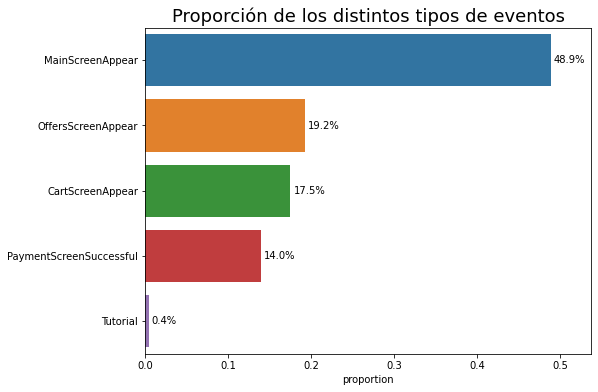

In [109]:
# observemos la distribucion de los tipos de eventos
fig,ax=plt.subplots(figsize=(8,6))
ax=sns.barplot(data=data,x='proportion',y='event_name')

for rect in ax.patches:
    # Get X and Y placement of label from rect.
    x_value = rect.get_width()
    y_value = rect.get_y() + rect.get_height() / 2

    # Number of points between bar and label
    space = 3
    # Vertical alignment 'va'

    # Use X value as label and format percent
    label = "{:.1%}".format(x_value)

    # Create annotation
    ax.annotate(
        label,                      # Use `label` as label
        (x_value, y_value),         # Place label at end of the bar
        xytext=(space,0),          # Vertically shift label by `space`
        textcoords="offset points", # Interpret `xytext` as offset in points
        ha='left',                  # Horizontally center label
        va='center')     
    
plt.xlim(0,data['proportion'].max()*1.1)
plt.title('Proporción de los distintos tipos de eventos', fontsize=18)
plt.ylabel('')
plt.show()

Podemos observar que el evento 'MainScreenAppear' es el más frecuente, mientras que 'Tutorial' es el de menor ocurrencia.

In [110]:
# contamos la cantidad de usuarios unicos
("{:,}".format(logs_data['device_id_hash'].nunique()))

'7,551'

In [111]:
# contamos la cantidad de datos para cada tipo de prueba
print("El total de datos es: ",logs_data.shape[0])
logs_data['exp_id'].value_counts().map("{:,}".format)

El total de datos es:  243713


248    85,582
246    80,181
247    77,950
Name: exp_id, dtype: object

Podemos observar que la cantidad de datos para cada tipo de prueba no es el mismo, aunque si muy semejante. Tenemos 7,551 usuarios y 243,713 registros en el estudio.

## Histograma para la distribución de los datos

In [112]:
# veamos las fechas de inicio y final del set de datos
print("La fecha inicial es: ",logs_data['date'].min())
print("La fecha final es: ",logs_data['date'].max())
print("Días del estudio: ",(logs_data['date'].max()-logs_data['date'].min()).days)

La fecha inicial es:  2019-07-25 00:00:00
La fecha final es:  2019-08-07 00:00:00
Días del estudio:  13


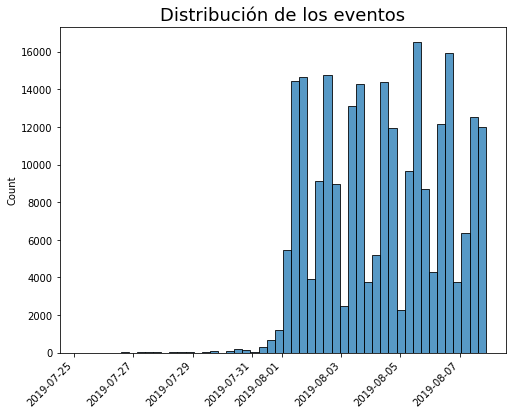

In [113]:
# creamos un histograma para la distribucion de los datos
data=logs_data['event_timestamp']
fig,ax=plt.subplots(figsize=(8,6))
ax=sns.histplot(data=data,bins=50)
plt.xticks(rotation=45,ha='right')
plt.title('Distribución de los eventos',fontsize=18)
plt.xlabel('')
plt.show()

Podemos observar que el rango de tiempo del estudio es de 13 días. A partir del día '2019-08-01' los datos empiezan a tener una distribución muy parecida, así que vamos a filtrar los datos a partir de dicha fecha.

In [114]:
# creamos un set de datos filtrado a partir del dia '2019-08-01'
filtered_logs=logs_data[logs_data['date']>='2019-08-01']

In [115]:
# dias de estudio para los datos filtrados
print("Días del estudio: ",(filtered_logs['date'].max()-filtered_logs['date'].min()).days)

Días del estudio:  6


**Tenemos seis días efectivos de datos para el estudio.**  Veamos cuántos datos y usuarios se perdieron al eliminar los datos más antiguos.

In [116]:
# contamos la cantidad de datos perdidos
("{:,}".format(logs_data.query("date<'2019-08-01'")['event_name'].count()))

'2,826'

In [117]:
# contamos la cantidad de usuarios perdidos
("{:,}".format(logs_data.query("date<'2019-08-01'")['device_id_hash'].nunique()))

'1,451'

**Al eliminar los datos más antiguos hemos perdido: 2,826 datos y 1,451 usuarios. Lo que nos representa 2,826/243,713=1.16% de los datos.**


In [118]:
# mostramos los porcentajes para las categorias en la columna 'exp_id' de los datos filtrados
filtered_logs['exp_id'].value_counts(normalize=True).map("{:.1%}".format)

248    35.1%
246    32.9%
247    32.0%
Name: exp_id, dtype: object

**Podemos notar que, en el conjunto de datos filtrados, tenemos presencia de los tres grupos experimentales y en proporciones muy similares.**

## Estudio del tipo de eventos

Para estudiar las métricas relacionadas con los tipos de eventos vamos a hacer uso del data set filtrado 'filtered_logs'.

***Tipo de evento y su frecuencia de uso***

In [119]:
# veamos el tipo de evento y su frecuencia de suceso
filtered_logs['event_name'].value_counts().map("{:,}".format)

MainScreenAppear           117,328
OffersScreenAppear          46,333
CartScreenAppear            42,303
PaymentScreenSuccessful     33,918
Tutorial                     1,005
Name: event_name, dtype: object

**Cantidad de usuarios por evento**

Calcularemos la proporción de usuarios que realizaron la acción al menos una vez.

In [120]:
# veamos la cantidad de usuarios por evento
proportion_users_event=filtered_logs.groupby('event_name').agg(users_event=('device_id_hash','nunique'))\
                        .sort_values('users_event',ascending=False).reset_index()
proportion_users_event['proportion']= proportion_users_event['users_event']/proportion_users_event['users_event'].sum()
proportion_users_event.style.format({"users_event":'{:,}',"proportion":'{:.1%}'})

,event_name,users_event,proportion
0,MainScreenAppear,"7,419",36.9%
1,OffersScreenAppear,"4,593",22.8%
2,CartScreenAppear,"3,734",18.6%
3,PaymentScreenSuccessful,"3,539",17.6%
4,Tutorial,840,4.2%


El evento llamado 'Tutorial' es el único que parece no pertenecer a la secuencia de los demás eventos.

**La secuencia de eventos está dada en el siguiente orden:**

1. MainScreenAppear

2. OffersScreenAppear

3. CartScreenAppear

4. PaymentScreenSuccessful

In [121]:
"""Creamos una función para un gráfico tipo Funnel"""

def crear_grafico_funnel(data,col_datos,col_etapas,formato="{:,.0f}",titulo='Grafico'):
    """
    data=el dataframe de datos con los valores de las etapas, ordenadas de mayor a menor
    col_datos=el nombre de la columna del dataframe que contiene los conteos de las etapas
    col_etapas=el nombre de la columna del dataframe con los nombre de las etapas
    formato= del tipo "{:,.0f}" que indica como se muestran las etiquetas de valores de col_datos
    titulo= el titulo del grafico ('Grafico')
    """
    fig,ax=plt.subplots(figsize=(10,5))
   
    ax=sns.barplot(data=data,x=col_datos,y=col_etapas)
    
    for rect in ax.patches:
    # Get X and Y placement of label from rect.
        x_value = rect.get_width()
        y_value = rect.get_y() + rect.get_height() / 2

        # Number of points between bar and label
        space = 3
        # Vertical alignment 'va'

        # Use X value as label and format percent
        label =formato.format(x_value)

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(space,0),          # Horizontally shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='left',                  # Horizontally center label
            va='center')     

    plt.tight_layout()
    plt.xlim(0,data[col_datos].max()*1.1)
    plt.xlabel('Usuarios')
    plt.ylabel('Evento')
    plt.title(titulo)
    plt.show()

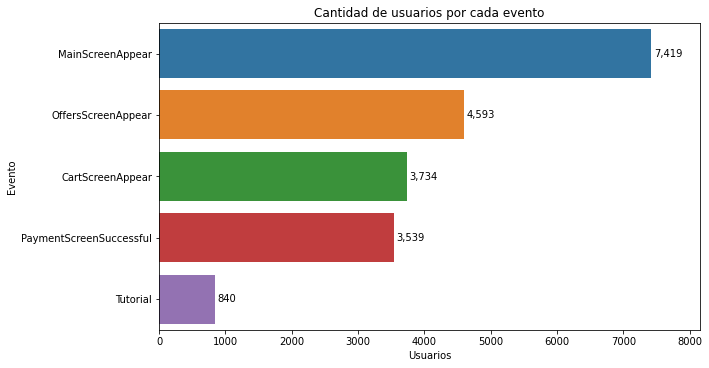

In [122]:
# creamos el grafico tipo funnel para la cantidad de eventos
crear_grafico_funnel(data=proportion_users_event,col_datos='users_event',col_etapas='event_name',\
                     titulo='Cantidad de usuarios por cada evento')

## Embudo de productos simples

Encontramos la proporción de usuarios que pasan de una etapa a la siguiente para responder a la pregunta: ¿En qué etapa se pierden más usuarios?

Hacemos uso del dataframe 'proportion_users_event' que contiene la cantidad de usuarios únicos en cada etapa.

In [123]:
# calculamos la cantidad de usuarios unicos en la primera etapa
n=proportion_users_event['users_event'].max()

# calculamos la conversion total en cada etapa
proportion_users_event['convertion_total']=proportion_users_event['users_event']/n

# desplazamos los elementos en la columna 'users_event' en una posicion
proportion_users_event['users_event_previuos_step']=proportion_users_event['users_event'].shift(1)
proportion_users_event['users_event_previuos_step'].fillna(n,inplace=True)

# calculamos la conversion a la siguiente etapa
proportion_users_event['convertion_previuos_step']=proportion_users_event['users_event']\
                                                /proportion_users_event['users_event_previuos_step']

# calculamos la tasa de perdida de usuarios
proportion_users_event['dropoff_rate']=1-proportion_users_event['convertion_previuos_step']

# eliminamos la columna 'users_event_previuos_step'
proportion_users_event.drop('users_event_previuos_step',inplace=True,axis=1)

# eliminamos la fila del evento 'Tutorial'
proportion_users_event.drop(4,inplace=True,axis=0)

proportion_users_event.style.format({"users_event":'{:,}','proportion':'{:.1%}',\
                                     'convertion_total':'{:.1%}','convertion_previuos_step':'{:.1%}',\
                                    'dropoff_rate':'{:.1%}'})

,event_name,users_event,proportion,convertion_total,convertion_previuos_step,dropoff_rate
0,MainScreenAppear,"7,419",36.9%,100.0%,100.0%,0.0%
1,OffersScreenAppear,"4,593",22.8%,61.9%,61.9%,38.1%
2,CartScreenAppear,"3,734",18.6%,50.3%,81.3%,18.7%
3,PaymentScreenSuccessful,"3,539",17.6%,47.7%,94.8%,5.2%


Al pasar de la etapa 'MainScreenAppear' a la etapa 'OffersScreenAppear' es cuando se pierden hasta el 38% de los usuarios ('dropoff_rate').

## Embudo de productos con secuencia de eventos

En esta sección estudiamos los detalles de la transición de una etapa a otra. Respondemos a la pregunta: ¿Qué porcentaje de usuarios hace todo el viaje desde su primer evento hasta el pago?

Hacemos uso del dataframe 'filtered_logs' que contiene la cantidad de usuarios únicos en cada etapa.



In [124]:
# embudos con secuencia de eventos
# para cada usuario debemos encontrar el momento en que se dio un paso en particular por 1ra vez
users=filtered_logs.pivot_table(index='device_id_hash',columns='event_name',values='event_timestamp',\
                               aggfunc='min')
users.sample(5)

event_name,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Tutorial
device_id_hash,,,,,
7235587238353002284,2019-08-06 16:59:06,2019-08-01 11:16:29,2019-08-06 14:30:56,2019-08-06 16:59:06,NaT
4734459598810529792,2019-08-01 10:00:36,2019-08-01 10:00:29,2019-08-01 10:00:45,2019-08-01 10:00:36,NaT
7398064750086769573,NaT,2019-08-07 16:53:58,NaT,NaT,2019-08-07 16:53:31
8577109005537401828,NaT,2019-08-01 08:40:54,NaT,NaT,NaT
7826449443626647741,2019-08-01 13:50:52,2019-08-01 12:53:40,2019-08-01 13:49:31,2019-08-02 08:25:51,2019-08-01 12:52:54


In [125]:
# creamos los pasos para cada etapa, el paso posterior debe cumplir con las condiciones del paso previo
step_1=users['MainScreenAppear'].notna()
step_2=step_1 & (users['OffersScreenAppear']>users['MainScreenAppear'])
step_3=step_2 & (users['CartScreenAppear']>users['OffersScreenAppear'])
step_4=step_3 & (users['PaymentScreenSuccessful']>users['CartScreenAppear'])

In [126]:
# busquemos ahora los usuarios que completaron el primer paso 'MainScreenAppear'
n_users_step_1=users[step_1].shape[0]
n_users_step_1

7419

In [127]:
# busquemos ahora los usuarios que completaron el segundo paso 'OffersScreenAppear'
n_users_step_2=users[step_2].shape[0]
n_users_step_2

4201

In [128]:
# busquemos ahora los usuarios que completaron el tercer paso 'CartScreenAppear'
n_users_step_3=users[step_3].shape[0]
n_users_step_3

1767

In [129]:
# busquemos ahora los usuarios que completaron el cuarto paso 'PaymentScreenSuccessful'
n_users_step_4=users[step_4].shape[0]
n_users_step_4

454

In [130]:
# calculamos el porcentaje de usuarios que completaron del primero al ultimo paso
("{:.1%}".format(n_users_step_4/n_users_step_1))

'6.1%'

In [131]:
# calculamos el porcentaje de usuarios que realizaron un pago después de agregar un producto al carrito
("{:.1%}".format(n_users_step_4/n_users_step_3))

'25.7%'

**Tenemos que solo un 6.1% de los usuarios completaron del primer evento hasta el pago. Solo un 25.7% de los usuarios que agregaron un producto al carrito terminaron de realizar el pago.**

In [132]:
# creamos un dataframe para los usuarios en la secuencia de eventos
users_event=pd.DataFrame({"etapas":['MainScreenAppear','OffersScreenAppear','CartScreenAppear','PaymentScreenSuccessful'],\
                         "users":[n_users_step_1,n_users_step_2,n_users_step_3,n_users_step_4]})

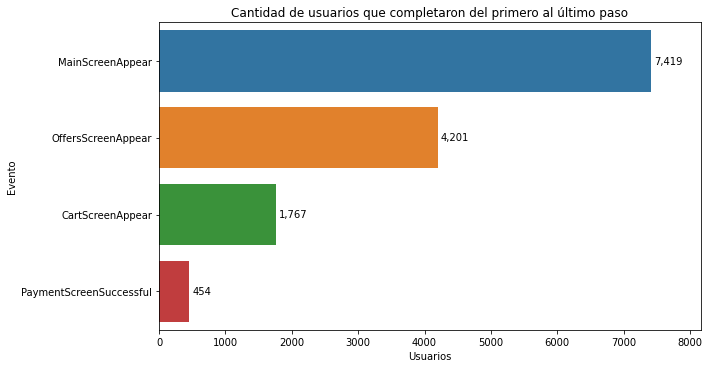

In [133]:
# creamos el gráfico tipo funnel para la secuencia de eventos
crear_grafico_funnel(data=users_event,col_datos='users',col_etapas='etapas',\
                     titulo='Cantidad de usuarios que completaron del primero al último paso')

## Pruebas A/A/B

In [134]:
filtered_logs.head()

,event_name,device_id_hash,event_timestamp,exp_id,date
2826,Tutorial,3737462046622621720,2019-08-01 00:07:28,246,2019-08-01
2827,MainScreenAppear,3737462046622621720,2019-08-01 00:08:00,246,2019-08-01
2828,MainScreenAppear,3737462046622621720,2019-08-01 00:08:55,246,2019-08-01
2829,OffersScreenAppear,3737462046622621720,2019-08-01 00:08:58,246,2019-08-01
2830,MainScreenAppear,1433840883824088890,2019-08-01 00:08:59,247,2019-08-01


En esta sección estudiamos las test A/B para comparar los dos grupos de control contra el grupo de prueba.

Hacemos uso del dataframe 'filtered_logs' que contiene la cantidad de usuarios únicos en cada etapa.

In [135]:
# contamos la cantidad de usuarios por grupo
filtered_logs['exp_id'].value_counts()

248    84563
246    79302
247    77022
Name: exp_id, dtype: int64

In [136]:
# contamos la cantidad de eventos para grupo
filtered_logs.groupby('event_name')['exp_id'].value_counts()

event_name               exp_id
CartScreenAppear         248       15179
                         246       14690
                         247       12434
MainScreenAppear         248       40562
                         247       39090
                         246       37676
OffersScreenAppear       248       16387
                         247       15179
                         246       14767
PaymentScreenSuccessful  248       12085
                         246       11852
                         247        9981
Tutorial                 248         350
                         247         338
                         246         317
Name: exp_id, dtype: int64

La cantidad de registros en cada uno de los grupos de control y prueba es muy parecido. Mientras que el evento más popular es 'MainScreenAppear'.

### Comparación entre los grupos de control y el grupo de prueba


Para cada uno de los eventos y los grupos de control o prueba probaremos si existe diferencia entre los grupos. Vamos a calcular la tasa de conversión de los usuarios en cada uno de los grupos.

In [137]:
"""Creamos una función para realizar una t-test sobre dos grupos y cada uno de los eventos"""
def ttest_comparation(data,group_1,group_2,alfa,eventos):
    """
    data= el dataframe que contiene los datos filtrados para el estudio
    group_1=el grupo_1 donde se realizará la prueba
    group_2=el group_2 donde se realizará la prueba
    alfa=el nivel de significancia para la prueba
    p1,n_group_1=la proporcion y el tamaño de la muestra del grupo_1
    p2,n_group_2=la proporcion y el tamaño de la muestra del grupo_2
    decision_H0= si se rechaza o no H0
    eventos=la lista que contiene los nombres de los eventos para los que se va a realizar la prueba
    """
    # creamos un dataframe para guardar los resultados de las pruebas
    df = pd.DataFrame(columns=['event_name', 'statistics','p_value','alfa','p1','n_group_1',\
                               'p2','n_group_2','decision_H0','grupos_comparados'])
    
    # creamos el ciclo para recorrer la lista de eventos
    for event in eventos:    
        # para cada usuario y grupo vamos a crear una lista
        conversions=data[['device_id_hash','exp_id']].drop_duplicates()

        # obtenemos los usuarios convertidos para un evento
        converted=pd.DataFrame(data={
                        "device_id_hash":data[data['event_name']==event]\
                        ['device_id_hash'].unique(),"converted":1})

        # unimos 'conversions' con 'converted' para crear el dataframe de los usuarios convertidos en el evento
        conversions=conversions.merge(converted,on="device_id_hash",how="left")

        # para los usuarios no convertidos rellenamos con 'cero'
        conversions['converted']=conversions['converted'].fillna(0)

        # creamos la muestra para el group_1
        sample_group_1=conversions[conversions['exp_id']==group_1]['converted']
        # obtenemos el tamaño de la muestra
        n1=len(sample_group_1)
        # obtenemos la proporcion de  usuarios convertidos
        p1=sample_group_1.mean()

        # creamos la muestra para el group_2
        sample_group_2=conversions[conversions['exp_id']==group_2]['converted']
        # obtenemos el tamaño de la muestra
        n2=len(sample_group_2)
        # obtenemos la proporcion de  usuarios convertidos
        p2=sample_group_2.mean()

        # realizamos la prueba
        statistics,p_value=st.ttest_ind(sample_group_1,sample_group_2)
        
        # decision de la prueba, rechazar H0 si:
        if p_value < alfa:
            decision='Rechazar H0'
        else:
            decision='No rechazar H0'

        # guardamos cada uno de los resultados de la prueba en el dataframe
        df.loc[len(df)] = [event,statistics,p_value,alfa,p1,n1,p2,n2,decision,\
                           str(group_1)+" vs "+str(group_2)]
        
    return df

In [138]:
# obtenemos la lista de los eventos a aplicar la prueba
eventos=filtered_logs[~filtered_logs['event_name'].isin(['Tutorial'])]['event_name'].unique()

**Probaremos la hipótesis siguiente para cada tipo de evento:**

**° Hipótesis nula:** la cantidad de usuarios convertidos en los grupos comparados es el mismo.

**° Hipótesis alternativa:** la cantidad de usuarios convertidos en los grupos comparados no es el mismo.

Ya que vamos a comparar la media de dos poblaciones, usaremos la prueba estadística 't de Student' (ttes_ind) con un nivel alpha=0.05 de significancia. Consideraremos las varianzas de los grupos como iguales.

In [139]:
# aplicamos la funcion para realizar las pruebas t-test sobre los eventos y grupos de control
ttest_comparation(data=filtered_logs,group_1=246,group_2=247,alfa=0.05,eventos=eventos)

,event_name,statistics,p_value,alfa,p1,n_group_1,p2,n_group_2,decision_H0,grupos_comparados
0,MainScreenAppear,0.309285,0.757117,0.05,0.986312,2484,0.985277,2513,No rechazar H0,246 vs 247
1,OffersScreenAppear,1.154911,0.248182,0.05,0.620773,2484,0.604855,2513,No rechazar H0,246 vs 247
2,CartScreenAppear,1.203302,0.228916,0.05,0.509662,2484,0.492638,2513,No rechazar H0,246 vs 247
3,PaymentScreenSuccessful,1.578072,0.114612,0.05,0.483092,2484,0.460804,2513,No rechazar H0,246 vs 247



Para la comparación de los grupos de control (246 y 247), la proporción de los usuarios convertidos en cada uno de los eventos no se encuentran diferencias significativas, usando un valor alfa de 5%.

In [140]:
# aplicamos la funcion para realizar las pruebas t-test sobre los eventos y grupos
ttest_comparation(data=filtered_logs,group_1=246,group_2=248,alfa=0.05,eventos=eventos)

,event_name,statistics,p_value,alfa,p1,n_group_1,p2,n_group_2,decision_H0,grupos_comparados
0,MainScreenAppear,1.047182,0.295066,0.05,0.986312,2484,0.982657,2537,No rechazar H0,246 vs 248
1,OffersScreenAppear,1.258030,0.208439,0.05,0.620773,2484,0.603469,2537,No rechazar H0,246 vs 248
2,CartScreenAppear,1.760066,0.078458,0.05,0.509662,2484,0.484825,2537,No rechazar H0,246 vs 248
3,PaymentScreenSuccessful,1.247333,0.212334,0.05,0.483092,2484,0.465510,2537,No rechazar H0,246 vs 248



Para la comparación del grupo de control "246" versus el grupo de prueba "248", la proporción de los usuarios convertidos en cada uno de los eventos no se encuentran diferencias significativas, usando un valor alfa de 5%.

In [141]:
# aplicamos la funcion para realizar las pruebas t-test sobre los eventos y grupos
ttest_comparation(data=filtered_logs,group_1=247,group_2=248,alfa=0.05,eventos=eventos)

,event_name,statistics,p_value,alfa,p1,n_group_1,p2,n_group_2,decision_H0,grupos_comparados
0,MainScreenAppear,0.740874,0.458804,0.05,0.985277,2513,0.982657,2537,No rechazar H0,247 vs 248
1,OffersScreenAppear,0.100689,0.919802,0.05,0.604855,2513,0.603469,2537,No rechazar H0,247 vs 248
2,CartScreenAppear,0.555309,0.578708,0.05,0.492638,2513,0.484825,2537,No rechazar H0,247 vs 248
3,PaymentScreenSuccessful,-0.335313,0.737403,0.05,0.460804,2513,0.465510,2537,No rechazar H0,247 vs 248



Para la comparación del grupo de control "247" versus el grupo de prueba "248", la proporción de los usuarios convertidos en cada uno de los eventos no se encuentran diferencias significativas, usando un valor alfa de 5%.

Para realizar la prueba combinada de los dos grupos de control versus el grupo de prueba vamos a crear un solo grupo de control.

In [142]:
# creamos una copia del dataframe 'filtered_logs' para hacer un reemplazo
filtered_logs_copy=filtered_logs.copy()

In [143]:
# reemplazamos el grupo de control '246' por el '247' para tener un solo grupo de control '247'
filtered_logs_copy.loc[filtered_logs_copy['exp_id']==246,'exp_id']=247

In [144]:
# verificamos que se haya hecho el reemplazo
filtered_logs_copy['exp_id'].value_counts()

247    156324
248     84563
Name: exp_id, dtype: int64

In [145]:
# aplicamos la funcion para realizar las pruebas t-test sobre los eventos y grupos
ttest_comparation(data=filtered_logs_copy,group_1=247,group_2=248,alfa=0.05,eventos=eventos)

,event_name,statistics,p_value,alfa,p1,n_group_1,p2,n_group_2,decision_H0,grupos_comparados
0,MainScreenAppear,1.048791,0.294308,0.05,0.985791,4997,0.982657,2537,No rechazar H0,247 vs 248
1,OffersScreenAppear,0.781858,0.434322,0.05,0.612768,4997,0.603469,2537,No rechazar H0,247 vs 248
2,CartScreenAppear,1.335340,0.181805,0.05,0.501101,4997,0.484825,2537,No rechazar H0,247 vs 248
3,PaymentScreenSuccessful,0.523723,0.600487,0.05,0.471883,4997,0.465510,2537,No rechazar H0,247 vs 248


Para la comparación de los grupos de control combinados versus el grupo de prueba, la proporción de los usuarios convertidos en cada uno de los eventos no se encuentran diferencias significativas, usando un valor alfa de 5%.

## Nivel de significancia para la familia de pruebas realizadas

Para estudiar el nivel de significación conjunto de las pruebas vamos contabilizar la cantidad total de pruebas realizadas y el nivel de significancia empleado en cada prueba.

Hemos realizado un total de 16 pruebas 't-test' usando un valor alfa=0.05.

El ajuste de Bonferroni se calcula realizando el número de pruebas y dividiéndolo por el valor alfa.

es la tasa de error asociada a la famila de pruebas (FWER). Podemos ver que incrementa a medida que el número de pruebas incrementa. Para asegurar que la FWER es a lo más 
 podemos hacer uso de la correción de Bonferroni 


In [146]:
# cantidad de pruebas
n_pruebas=16
# nivel de significancia empleado
alfa=0.05

# Nivel de significancia de la familia de pruebas
alfa_real=1-(1-alfa)**n_pruebas

print(f"Nivel de significancia real:{alfa_real}")

Nivel de significancia real:0.5598733313482347


Si aplicamos la correción de Bonferroni para alcanzar el nivel de significancia para el total de las pruebas realizadas debemos probar cada una de las hipótesis empleando un valor alfa en cada prueba de:

In [147]:
# calculamos el nivel de significancia a usar en cada prueba para alcanzar el nivel alfa=0.05 para la familia de pruebas
alfa_per_comparison=alfa/n_pruebas
alfa_per_comparison

0.003125

Debemos entonces probar cada hipótesis usando un nivel alfa=0.003125 para poder alcanzar un nivel del 5% de significancia en el grupo de pruebas realizadas. Volvamos a realizar las pruebas empleando un nivel alfa=0.003125 en cada prueba.

In [148]:

# aplicamos la funcion para realizar las pruebas t-test sobre los eventos y grupos de control
ttest_comparation(data=filtered_logs,group_1=246,group_2=247,alfa=0.003125,eventos=eventos)

,event_name,statistics,p_value,alfa,p1,n_group_1,p2,n_group_2,decision_H0,grupos_comparados
0,MainScreenAppear,0.309285,0.757117,0.003125,0.986312,2484,0.985277,2513,No rechazar H0,246 vs 247
1,OffersScreenAppear,1.154911,0.248182,0.003125,0.620773,2484,0.604855,2513,No rechazar H0,246 vs 247
2,CartScreenAppear,1.203302,0.228916,0.003125,0.509662,2484,0.492638,2513,No rechazar H0,246 vs 247
3,PaymentScreenSuccessful,1.578072,0.114612,0.003125,0.483092,2484,0.460804,2513,No rechazar H0,246 vs 247


In [149]:

# aplicamos la funcion para realizar las pruebas t-test sobre los eventos y grupos de control
ttest_comparation(data=filtered_logs,group_1=246,group_2=248,alfa=0.003125,eventos=eventos)

,event_name,statistics,p_value,alfa,p1,n_group_1,p2,n_group_2,decision_H0,grupos_comparados
0,MainScreenAppear,1.047182,0.295066,0.003125,0.986312,2484,0.982657,2537,No rechazar H0,246 vs 248
1,OffersScreenAppear,1.258030,0.208439,0.003125,0.620773,2484,0.603469,2537,No rechazar H0,246 vs 248
2,CartScreenAppear,1.760066,0.078458,0.003125,0.509662,2484,0.484825,2537,No rechazar H0,246 vs 248
3,PaymentScreenSuccessful,1.247333,0.212334,0.003125,0.483092,2484,0.465510,2537,No rechazar H0,246 vs 248


In [150]:
# aplicamos la funcion para realizar las pruebas t-test sobre los eventos y grupos de control
ttest_comparation(data=filtered_logs,group_1=247,group_2=248,alfa=0.003125,eventos=eventos)

,event_name,statistics,p_value,alfa,p1,n_group_1,p2,n_group_2,decision_H0,grupos_comparados
0,MainScreenAppear,0.740874,0.458804,0.003125,0.985277,2513,0.982657,2537,No rechazar H0,247 vs 248
1,OffersScreenAppear,0.100689,0.919802,0.003125,0.604855,2513,0.603469,2537,No rechazar H0,247 vs 248
2,CartScreenAppear,0.555309,0.578708,0.003125,0.492638,2513,0.484825,2537,No rechazar H0,247 vs 248
3,PaymentScreenSuccessful,-0.335313,0.737403,0.003125,0.460804,2513,0.465510,2537,No rechazar H0,247 vs 248


In [151]:
# aplicamos la funcion para realizar las pruebas t-test sobre los eventos y grupos
ttest_comparation(data=filtered_logs_copy,group_1=247,group_2=248,alfa=0.003125,eventos=eventos)

,event_name,statistics,p_value,alfa,p1,n_group_1,p2,n_group_2,decision_H0,grupos_comparados
0,MainScreenAppear,1.048791,0.294308,0.003125,0.985791,4997,0.982657,2537,No rechazar H0,247 vs 248
1,OffersScreenAppear,0.781858,0.434322,0.003125,0.612768,4997,0.603469,2537,No rechazar H0,247 vs 248
2,CartScreenAppear,1.335340,0.181805,0.003125,0.501101,4997,0.484825,2537,No rechazar H0,247 vs 248
3,PaymentScreenSuccessful,0.523723,0.600487,0.003125,0.471883,4997,0.465510,2537,No rechazar H0,247 vs 248


Podemos notar que en ninguna de las pruebas se rechaza la hipótesis nula y además con el valor de significancia alfa=0.003125 en cada prueba podemos alcanzar un nivel general de significancia menor a 0.05.

In [152]:
# comprobamos el nivel de significancia para la familia de pruebas
alfa_real=1-(1-alfa_per_comparison)**n_pruebas
alfa_real

0.048845042569365726

# Conlusión



No se encontraron diferencias significativas entre los grupos de control y el grupo de prueba para el uso de la aplicación. No esperamos comportamientos distintos de los usuarios ante la nueva implementación.